# Object Detection V1

Based on code from [this repo](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)

## Initial Setup

Auto update from code base

In [1]:
%load_ext autoreload
%autoreload 2

Import libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import json
import xml.etree.ElementTree as ET
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

from src.data import pil_loader
from src.object_detection.model import SSD300, MultiBoxLoss
from src.object_detection.datasets import PascalVOCDataset
from src.object_detection.training import train, validate
from src.object_detection.evaluation import evaluate
from src.object_detection.detection import detect
from src.object_detection.utils import *

Data parameters

In [3]:
data_folder = 'data/derived'
keep_difficult = True

Load datasets and label_maps

In [4]:
with open(os.path.join(data_folder, 'label_map_beauty.json'), 'r') as j:
    label_map_beauty = json.load(j)
    
with open(os.path.join(data_folder, 'label_map_fashion.json'), 'r') as j:
    label_map_fashion = json.load(j)
    
with open(os.path.join(data_folder, 'label_map_mobile.json'), 'r') as j:
    label_map_mobile = json.load(j)

Model parameters

In [5]:
n_classes_beauty = len(label_map_beauty)
n_classes_fashion = len(label_map_fashion)
n_classes_mobile = len(label_map_mobile)
print(n_classes_beauty, n_classes_fashion, n_classes_mobile)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

3 2 3
cuda


## Training and Validation

Beauty

In [6]:
# Learning parameters

batch_size = 8  # batch size
start_epoch = 0  # start at this epoch
epochs = 100  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
patience = 10  # allowed number of epochs since improvement in validation metric before learning rate is adjusted
best_loss = 100.  # assume a high loss at first
workers = 8  # number of workers for loading data in the DataLoader
print_freq = 10  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [7]:
# path to model checkpoint, None if none
cp_path = 'models/checkpoint_beauty.pth.tar'
if os.path.exists(cp_path):
    checkpoint = cp_path
else:
    checkpoint = None

# Initialize model or load checkpoint
if checkpoint is None:
    model_beauty = SSD300(n_classes=n_classes_beauty, device=device)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model_beauty.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model_beauty = checkpoint['model']
    optimizer = checkpoint['optimizer']
        
# Move to default device
model_beauty = model_beauty.to(device)
criterion = MultiBoxLoss(priors_cxcy=model_beauty.priors_cxcy, device=device).to(device)

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 image_category='beauty',
                                 split='train',
                                 keep_difficult=keep_difficult)
val_dataset = PascalVOCDataset(data_folder,
                               image_category='beauty',
                               split='test',
                               keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  # note that we're passing the collate function here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                         collate_fn=val_dataset.collate_fn, num_workers=workers,
                                         pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):
    # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
    # The paper uses a batch size of 32, which means there were about 517 iterations in an epoch
    # Therefore, to find the epochs to decay at, you could do,
    # if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
    #     adjust_learning_rate(optimizer, 0.1)

    # In practice, I just decayed the learning rate when loss stopped improving for long periods,
    # and I would resume from the last best checkpoint with the new learning rate,
    # since there's no point in resuming at the most recent and significantly worse checkpoint.
    # So, when you're ready to decay the learning rate, just set checkpoint = 'BEST_checkpoint_ssd300.pth.tar' above
    # and have adjust_learning_rate(optimizer, 0.1) BEFORE this 'for' loop
    
    # Adjust learning rate if no improvement in validation metric over a specified number of epochs
    if (epochs_since_improvement % patience == 0) and (epochs_since_improvement != 0):
        optimizer = adjust_learning_rate(optimizer, 0.1)

    # One epoch's training
    model_beauty = train(train_loader=train_loader,
                         model=model_beauty,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch,
                         grad_clip=grad_clip,
                         print_freq=print_freq,
                         device=device)

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model_beauty,
                        criterion=criterion,
                        device=device,
                        print_freq=print_freq)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint('checkpoint_beauty.pth.tar', 'models', epoch, epochs_since_improvement,
                    model_beauty, optimizer, val_loss, best_loss, is_best)


Loaded base model.



/home/yxlee245/anaconda3/envs/ndsc2019_env/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/63]	Batch Time 23.516 (23.516)	Data Time 1.097 (1.097)	Loss 17.2716 (17.2716)	
Epoch: [0][10/63]	Batch Time 0.646 (2.722)	Data Time 0.000 (0.100)	Loss 6.1625 (9.2066)	
Epoch: [0][20/63]	Batch Time 0.645 (1.735)	Data Time 0.000 (0.053)	Loss 5.5724 (7.8714)	
Epoch: [0][30/63]	Batch Time 0.643 (1.384)	Data Time 0.000 (0.036)	Loss 6.1390 (7.4449)	
Epoch: [0][40/63]	Batch Time 0.647 (1.203)	Data Time 0.000 (0.027)	Loss 5.4769 (7.1302)	
Epoch: [0][50/63]	Batch Time 0.647 (1.094)	Data Time 0.000 (0.022)	Loss 6.8509 (6.9275)	
Epoch: [0][60/63]	Batch Time 0.643 (1.020)	Data Time 0.000 (0.018)	Loss 5.1992 (6.8083)	
[0/24]	Batch Time 0.815 (0.815)	Loss 6.4276 (6.4276)	
[10/24]	Batch Time 0.243 (0.296)	Loss 6.5787 (5.7748)	
[20/24]	Batch Time 0.243 (0.270)	Loss 5.8987 (5.7484)	

 * LOSS - 5.751

Epoch: [1][0/63]	Batch Time 2.941 (2.941)	Data Time 2.171 (2.171)	Loss 5.4800 (5.4800)	
Epoch: [1][10/63]	Batch Time 0.648 (0.861)	Data Time 0.000 (0.198)	Loss 5.2250 (6.3700)	
Epoch: [1][20/6

Epoch: [10][10/63]	Batch Time 0.653 (0.839)	Data Time 0.000 (0.166)	Loss 3.6843 (3.8900)	
Epoch: [10][20/63]	Batch Time 0.645 (0.748)	Data Time 0.000 (0.087)	Loss 3.4986 (3.7084)	
Epoch: [10][30/63]	Batch Time 0.651 (0.716)	Data Time 0.000 (0.059)	Loss 3.6921 (3.7682)	
Epoch: [10][40/63]	Batch Time 0.648 (0.699)	Data Time 0.000 (0.045)	Loss 3.5452 (3.7549)	
Epoch: [10][50/63]	Batch Time 0.645 (0.689)	Data Time 0.000 (0.036)	Loss 3.8573 (3.7542)	
Epoch: [10][60/63]	Batch Time 0.644 (0.682)	Data Time 0.000 (0.030)	Loss 4.0021 (3.7630)	
[0/24]	Batch Time 1.097 (1.097)	Loss 3.5771 (3.5771)	
[10/24]	Batch Time 0.245 (0.323)	Loss 3.3868 (3.7017)	
[20/24]	Batch Time 0.243 (0.285)	Loss 3.4222 (3.8052)	

 * LOSS - 3.840

Epoch: [11][0/63]	Batch Time 2.990 (2.990)	Data Time 2.189 (2.189)	Loss 3.2382 (3.2382)	
Epoch: [11][10/63]	Batch Time 0.647 (0.868)	Data Time 0.000 (0.199)	Loss 3.8231 (3.5570)	
Epoch: [11][20/63]	Batch Time 0.650 (0.765)	Data Time 0.000 (0.105)	Loss 3.6200 (3.6517)	
Epoch: [1

Epoch: [20][10/63]	Batch Time 0.649 (0.922)	Data Time 0.000 (0.264)	Loss 2.8981 (3.1149)	
Epoch: [20][20/63]	Batch Time 0.643 (0.791)	Data Time 0.000 (0.138)	Loss 2.8462 (3.0749)	
Epoch: [20][30/63]	Batch Time 0.645 (0.746)	Data Time 0.000 (0.094)	Loss 3.3912 (3.1503)	
Epoch: [20][40/63]	Batch Time 0.646 (0.721)	Data Time 0.000 (0.071)	Loss 2.6854 (3.1151)	
Epoch: [20][50/63]	Batch Time 0.641 (0.706)	Data Time 0.000 (0.057)	Loss 2.5816 (3.1088)	
Epoch: [20][60/63]	Batch Time 0.645 (0.696)	Data Time 0.000 (0.048)	Loss 3.1384 (3.0971)	
[0/24]	Batch Time 1.149 (1.149)	Loss 4.5595 (4.5595)	
[10/24]	Batch Time 0.243 (0.325)	Loss 3.1553 (3.7997)	
[20/24]	Batch Time 0.242 (0.286)	Loss 4.0189 (3.6216)	

 * LOSS - 3.581


Epochs since last improvement: 2

Epoch: [21][0/63]	Batch Time 4.029 (4.029)	Data Time 3.272 (3.272)	Loss 3.4144 (3.4144)	
Epoch: [21][10/63]	Batch Time 0.646 (0.962)	Data Time 0.000 (0.298)	Loss 3.0189 (3.1618)	
Epoch: [21][20/63]	Batch Time 0.645 (0.813)	Data Time 0.000 (0.1


 * LOSS - 3.517


Epochs since last improvement: 1

Epoch: [30][0/63]	Batch Time 2.452 (2.452)	Data Time 1.668 (1.668)	Loss 2.2780 (2.2780)	
Epoch: [30][10/63]	Batch Time 0.650 (0.828)	Data Time 0.000 (0.152)	Loss 2.3363 (2.5134)	
Epoch: [30][20/63]	Batch Time 0.653 (0.742)	Data Time 0.000 (0.080)	Loss 2.1080 (2.6284)	
Epoch: [30][30/63]	Batch Time 0.648 (0.711)	Data Time 0.000 (0.054)	Loss 2.7851 (2.6774)	
Epoch: [30][40/63]	Batch Time 0.642 (0.695)	Data Time 0.000 (0.041)	Loss 3.3055 (2.7540)	
Epoch: [30][50/63]	Batch Time 0.634 (0.684)	Data Time 0.000 (0.033)	Loss 2.8274 (2.7472)	
Epoch: [30][60/63]	Batch Time 0.643 (0.677)	Data Time 0.000 (0.028)	Loss 2.7946 (2.7440)	
[0/24]	Batch Time 0.885 (0.885)	Loss 4.2435 (4.2435)	
[10/24]	Batch Time 0.243 (0.304)	Loss 3.0017 (3.6847)	
[20/24]	Batch Time 0.244 (0.275)	Loss 2.8736 (3.4380)	

 * LOSS - 3.480


Epochs since last improvement: 2

Epoch: [31][0/63]	Batch Time 2.943 (2.943)	Data Time 2.178 (2.178)	Loss 2.8748 (2.8748)	
Epoch: [31][

[0/24]	Batch Time 0.911 (0.911)	Loss 4.5301 (4.5301)	
[10/24]	Batch Time 0.243 (0.305)	Loss 2.7381 (3.3672)	
[20/24]	Batch Time 0.243 (0.276)	Loss 3.5827 (3.5149)	

 * LOSS - 3.481


Epochs since last improvement: 8

Epoch: [40][0/63]	Batch Time 2.661 (2.661)	Data Time 1.883 (1.883)	Loss 2.5899 (2.5899)	
Epoch: [40][10/63]	Batch Time 0.648 (0.842)	Data Time 0.000 (0.175)	Loss 2.9311 (2.5580)	
Epoch: [40][20/63]	Batch Time 0.641 (0.748)	Data Time 0.000 (0.092)	Loss 2.4509 (2.4939)	
Epoch: [40][30/63]	Batch Time 0.648 (0.715)	Data Time 0.000 (0.062)	Loss 2.3275 (2.5048)	
Epoch: [40][40/63]	Batch Time 0.645 (0.698)	Data Time 0.000 (0.047)	Loss 2.2196 (2.4944)	
Epoch: [40][50/63]	Batch Time 0.649 (0.688)	Data Time 0.000 (0.038)	Loss 2.3397 (2.5381)	
Epoch: [40][60/63]	Batch Time 0.649 (0.681)	Data Time 0.000 (0.032)	Loss 2.7589 (2.5448)	
[0/24]	Batch Time 0.943 (0.943)	Loss 4.3530 (4.3530)	
[10/24]	Batch Time 0.240 (0.308)	Loss 2.3139 (3.4771)	
[20/24]	Batch Time 0.245 (0.277)	Loss 2.4391 

Epoch: [49][50/63]	Batch Time 0.648 (0.692)	Data Time 0.000 (0.043)	Loss 2.4857 (2.3118)	
Epoch: [49][60/63]	Batch Time 0.648 (0.684)	Data Time 0.000 (0.036)	Loss 2.4440 (2.3173)	
[0/24]	Batch Time 0.884 (0.884)	Loss 3.0677 (3.0677)	
[10/24]	Batch Time 0.242 (0.304)	Loss 5.5943 (3.9046)	
[20/24]	Batch Time 0.245 (0.275)	Loss 2.3777 (3.6022)	

 * LOSS - 3.519


Epochs since last improvement: 8

Epoch: [50][0/63]	Batch Time 3.235 (3.235)	Data Time 2.417 (2.417)	Loss 2.2143 (2.2143)	
Epoch: [50][10/63]	Batch Time 0.644 (0.884)	Data Time 0.000 (0.220)	Loss 2.4232 (2.4004)	
Epoch: [50][20/63]	Batch Time 0.640 (0.770)	Data Time 0.000 (0.115)	Loss 2.4904 (2.3711)	
Epoch: [50][30/63]	Batch Time 0.646 (0.729)	Data Time 0.000 (0.078)	Loss 2.5992 (2.3523)	
Epoch: [50][40/63]	Batch Time 0.640 (0.709)	Data Time 0.000 (0.059)	Loss 2.2286 (2.3617)	
Epoch: [50][50/63]	Batch Time 0.649 (0.697)	Data Time 0.000 (0.048)	Loss 2.3433 (2.3237)	
Epoch: [50][60/63]	Batch Time 0.632 (0.688)	Data Time 0.000 (0.0

Epoch: [59][20/63]	Batch Time 0.649 (0.792)	Data Time 0.000 (0.134)	Loss 1.7176 (2.0378)	
Epoch: [59][30/63]	Batch Time 0.645 (0.746)	Data Time 0.000 (0.091)	Loss 2.1448 (2.0461)	
Epoch: [59][40/63]	Batch Time 0.648 (0.722)	Data Time 0.000 (0.069)	Loss 2.2063 (2.0347)	
Epoch: [59][50/63]	Batch Time 0.648 (0.707)	Data Time 0.000 (0.055)	Loss 1.6736 (2.0497)	
Epoch: [59][60/63]	Batch Time 0.652 (0.697)	Data Time 0.000 (0.046)	Loss 2.4206 (2.0391)	
[0/24]	Batch Time 1.043 (1.043)	Loss 2.4104 (2.4104)	
[10/24]	Batch Time 0.245 (0.317)	Loss 5.4419 (3.4328)	
[20/24]	Batch Time 0.245 (0.283)	Loss 3.2866 (3.3843)	

 * LOSS - 3.313


Epochs since last improvement: 5

Epoch: [60][0/63]	Batch Time 3.763 (3.763)	Data Time 2.972 (2.972)	Loss 2.3139 (2.3139)	
Epoch: [60][10/63]	Batch Time 0.645 (0.934)	Data Time 0.000 (0.270)	Loss 2.1183 (2.0645)	
Epoch: [60][20/63]	Batch Time 0.640 (0.795)	Data Time 0.000 (0.142)	Loss 2.0762 (1.9975)	
Epoch: [60][30/63]	Batch Time 0.638 (0.747)	Data Time 0.000 (0.0

[20/24]	Batch Time 0.244 (0.273)	Loss 2.9216 (3.2442)	

 * LOSS - 3.308


Epochs since last improvement: 14

Epoch: [69][0/63]	Batch Time 2.483 (2.483)	Data Time 1.694 (1.694)	Loss 1.9810 (1.9810)	
Epoch: [69][10/63]	Batch Time 0.648 (0.908)	Data Time 0.000 (0.245)	Loss 1.9607 (1.9683)	
Epoch: [69][20/63]	Batch Time 0.652 (0.784)	Data Time 0.000 (0.128)	Loss 2.4939 (2.0083)	
Epoch: [69][30/63]	Batch Time 0.653 (0.741)	Data Time 0.000 (0.087)	Loss 2.1336 (2.0296)	
Epoch: [69][40/63]	Batch Time 0.648 (0.719)	Data Time 0.000 (0.066)	Loss 2.3220 (2.0398)	
Epoch: [69][50/63]	Batch Time 0.650 (0.704)	Data Time 0.000 (0.053)	Loss 2.4049 (2.0497)	
Epoch: [69][60/63]	Batch Time 0.646 (0.695)	Data Time 0.000 (0.044)	Loss 2.1742 (2.0513)	
[0/24]	Batch Time 0.861 (0.861)	Loss 3.6057 (3.6057)	
[10/24]	Batch Time 0.244 (0.301)	Loss 3.7529 (3.2016)	
[20/24]	Batch Time 0.242 (0.274)	Loss 2.8878 (3.3404)	

 * LOSS - 3.363


Epochs since last improvement: 15

Epoch: [70][0/63]	Batch Time 3.158 (3.158)	D

Epoch: [78][50/63]	Batch Time 0.648 (0.692)	Data Time 0.000 (0.039)	Loss 1.7959 (1.9989)	
Epoch: [78][60/63]	Batch Time 0.645 (0.684)	Data Time 0.000 (0.032)	Loss 1.9739 (1.9705)	
[0/24]	Batch Time 1.002 (1.002)	Loss 5.0269 (5.0269)	
[10/24]	Batch Time 0.239 (0.315)	Loss 4.5637 (3.6305)	
[20/24]	Batch Time 0.242 (0.281)	Loss 3.1124 (3.3360)	

 * LOSS - 3.302


Epochs since last improvement: 24

Epoch: [79][0/63]	Batch Time 4.274 (4.274)	Data Time 3.501 (3.501)	Loss 2.4372 (2.4372)	
Epoch: [79][10/63]	Batch Time 0.662 (0.975)	Data Time 0.000 (0.319)	Loss 2.1994 (2.2694)	
Epoch: [79][20/63]	Batch Time 0.651 (0.816)	Data Time 0.000 (0.167)	Loss 2.0453 (2.1601)	
Epoch: [79][30/63]	Batch Time 0.650 (0.763)	Data Time 0.000 (0.113)	Loss 2.0840 (2.0932)	
Epoch: [79][40/63]	Batch Time 0.648 (0.735)	Data Time 0.000 (0.086)	Loss 1.6840 (2.0991)	
Epoch: [79][50/63]	Batch Time 0.646 (0.718)	Data Time 0.000 (0.069)	Loss 2.0833 (2.0554)	
Epoch: [79][60/63]	Batch Time 0.651 (0.706)	Data Time 0.000 (0.

Epoch: [88][20/63]	Batch Time 0.649 (0.767)	Data Time 0.000 (0.108)	Loss 2.0969 (1.9757)	
Epoch: [88][30/63]	Batch Time 0.669 (0.730)	Data Time 0.000 (0.073)	Loss 2.3494 (1.9961)	
Epoch: [88][40/63]	Batch Time 0.662 (0.710)	Data Time 0.000 (0.055)	Loss 1.4932 (2.0054)	
Epoch: [88][50/63]	Batch Time 0.645 (0.697)	Data Time 0.000 (0.045)	Loss 2.3414 (2.0391)	
Epoch: [88][60/63]	Batch Time 0.648 (0.689)	Data Time 0.000 (0.037)	Loss 2.1719 (2.0411)	
[0/24]	Batch Time 0.888 (0.888)	Loss 3.7882 (3.7882)	
[10/24]	Batch Time 0.241 (0.303)	Loss 3.3391 (3.2927)	
[20/24]	Batch Time 0.244 (0.275)	Loss 2.0676 (3.3447)	

 * LOSS - 3.287


Epochs since last improvement: 34

Epoch: [89][0/63]	Batch Time 3.475 (3.475)	Data Time 2.701 (2.701)	Loss 2.0289 (2.0289)	
Epoch: [89][10/63]	Batch Time 0.649 (0.914)	Data Time 0.000 (0.246)	Loss 1.9321 (1.9758)	
Epoch: [89][20/63]	Batch Time 0.659 (0.787)	Data Time 0.000 (0.129)	Loss 2.3559 (2.0980)	
Epoch: [89][30/63]	Batch Time 0.649 (0.743)	Data Time 0.000 (0.

[20/24]	Batch Time 0.242 (0.273)	Loss 2.9811 (3.3765)	

 * LOSS - 3.348


Epochs since last improvement: 43

Epoch: [98][0/63]	Batch Time 2.107 (2.107)	Data Time 1.393 (1.393)	Loss 1.7448 (1.7448)	
Epoch: [98][10/63]	Batch Time 0.641 (0.868)	Data Time 0.000 (0.213)	Loss 1.6883 (2.1467)	
Epoch: [98][20/63]	Batch Time 0.655 (0.763)	Data Time 0.000 (0.112)	Loss 2.2737 (2.0789)	
Epoch: [98][30/63]	Batch Time 0.643 (0.725)	Data Time 0.000 (0.076)	Loss 2.0317 (2.0661)	
Epoch: [98][40/63]	Batch Time 0.642 (0.705)	Data Time 0.000 (0.057)	Loss 1.7692 (2.0363)	
Epoch: [98][50/63]	Batch Time 0.639 (0.694)	Data Time 0.000 (0.046)	Loss 1.9696 (2.0514)	
Epoch: [98][60/63]	Batch Time 0.648 (0.686)	Data Time 0.000 (0.039)	Loss 1.3806 (2.0383)	
[0/24]	Batch Time 0.879 (0.879)	Loss 3.3189 (3.3189)	
[10/24]	Batch Time 0.246 (0.304)	Loss 5.1970 (3.2022)	
[20/24]	Batch Time 0.242 (0.275)	Loss 3.4518 (3.3157)	

 * LOSS - 3.289


Epochs since last improvement: 44

Epoch: [99][0/63]	Batch Time 2.827 (2.827)	D

Fashion

In [6]:
# Learning parameters

batch_size = 8  # batch size
start_epoch = 0  # start at this epoch
epochs = 100  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
patience = 10  # allowed number of epochs since improvement in validation metric before learning rate is adjusted
best_loss = 100.  # assume a high loss at first
workers = 8  # number of workers for loading data in the DataLoader
print_freq = 10  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [8]:
# path to model checkpoint, None if none
cp_path = 'models/checkpoint_fashion.pth.tar'
if os.path.exists(cp_path):
    checkpoint = cp_path
else:
    checkpoint = None

# Initialize model or load checkpoint
if checkpoint is None:
    model_fashion = SSD300(n_classes=n_classes_fashion, device=device)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model_fashion.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model_fashion = checkpoint['model']
    optimizer = checkpoint['optimizer']
        
# Move to default device
model_fashion = model_fashion.to(device)
criterion = MultiBoxLoss(priors_cxcy=model_fashion.priors_cxcy, device=device).to(device)

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 image_category='fashion',
                                 split='train',
                                 keep_difficult=keep_difficult)
val_dataset = PascalVOCDataset(data_folder,
                               image_category='fashion',
                               split='test',
                               keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  # note that we're passing the collate function here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                         collate_fn=val_dataset.collate_fn, num_workers=workers,
                                         pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):
    # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
    # The paper uses a batch size of 32, which means there were about 517 iterations in an epoch
    # Therefore, to find the epochs to decay at, you could do,
    # if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
    #     adjust_learning_rate(optimizer, 0.1)

    # In practice, I just decayed the learning rate when loss stopped improving for long periods,
    # and I would resume from the last best checkpoint with the new learning rate,
    # since there's no point in resuming at the most recent and significantly worse checkpoint.
    # So, when you're ready to decay the learning rate, just set checkpoint = 'BEST_checkpoint_ssd300.pth.tar' above
    # and have adjust_learning_rate(optimizer, 0.1) BEFORE this 'for' loop
    
    # Adjust learning rate if no improvement in validation metric over a specified number of epochs
    if (epochs_since_improvement % patience == 0) and (epochs_since_improvement != 0):
        optimizer = adjust_learning_rate(optimizer, 0.1)

    # One epoch's training
    model_fashion = train(train_loader=train_loader,
                         model=model_fashion,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch,
                         grad_clip=grad_clip,
                         print_freq=print_freq,
                         device=device)

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model_fashion,
                        criterion=criterion,
                        device=device,
                        print_freq=print_freq)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint('checkpoint_fashion.pth.tar', 'models', epoch, epochs_since_improvement,
                    model_fashion, optimizer, val_loss, best_loss, is_best)


Loaded base model.



/home/yxlee245/anaconda3/envs/ndsc2019_env/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/63]	Batch Time 25.328 (25.328)	Data Time 2.501 (2.501)	Loss 15.2083 (15.2083)	
Epoch: [0][10/63]	Batch Time 0.645 (2.889)	Data Time 0.000 (0.228)	Loss 4.8251 (7.4197)	
Epoch: [0][20/63]	Batch Time 0.659 (1.823)	Data Time 0.000 (0.119)	Loss 3.8125 (6.2513)	
Epoch: [0][30/63]	Batch Time 0.657 (1.446)	Data Time 0.000 (0.081)	Loss 5.7977 (5.7014)	
Epoch: [0][40/63]	Batch Time 0.647 (1.251)	Data Time 0.000 (0.061)	Loss 4.5236 (5.3815)	
Epoch: [0][50/63]	Batch Time 0.649 (1.133)	Data Time 0.000 (0.049)	Loss 4.0713 (5.1242)	
Epoch: [0][60/63]	Batch Time 0.645 (1.053)	Data Time 0.000 (0.041)	Loss 3.7850 (4.9320)	
[0/24]	Batch Time 1.143 (1.143)	Loss 4.7571 (4.7571)	
[10/24]	Batch Time 0.244 (0.326)	Loss 3.8040 (3.8698)	
[20/24]	Batch Time 0.243 (0.287)	Loss 3.7589 (3.8544)	

 * LOSS - 3.845

Epoch: [1][0/63]	Batch Time 2.740 (2.740)	Data Time 2.040 (2.040)	Loss 3.7684 (3.7684)	
Epoch: [1][10/63]	Batch Time 0.648 (0.881)	Data Time 0.000 (0.216)	Loss 3.8156 (4.1838)	
Epoch: [1][20/6

Epoch: [10][20/63]	Batch Time 0.652 (0.787)	Data Time 0.000 (0.133)	Loss 2.9030 (3.1168)	
Epoch: [10][30/63]	Batch Time 0.652 (0.745)	Data Time 0.000 (0.090)	Loss 2.9761 (3.1136)	
Epoch: [10][40/63]	Batch Time 0.654 (0.721)	Data Time 0.000 (0.068)	Loss 2.9906 (3.0953)	
Epoch: [10][50/63]	Batch Time 0.646 (0.707)	Data Time 0.000 (0.055)	Loss 3.2770 (3.0710)	
Epoch: [10][60/63]	Batch Time 0.650 (0.697)	Data Time 0.000 (0.046)	Loss 2.6878 (3.0475)	
[0/24]	Batch Time 0.995 (0.995)	Loss 2.6575 (2.6575)	
[10/24]	Batch Time 0.244 (0.316)	Loss 2.7973 (2.8427)	
[20/24]	Batch Time 0.245 (0.282)	Loss 2.7187 (2.8650)	

 * LOSS - 2.843

Epoch: [11][0/63]	Batch Time 3.097 (3.097)	Data Time 2.327 (2.327)	Loss 2.7305 (2.7305)	
Epoch: [11][10/63]	Batch Time 0.645 (0.928)	Data Time 0.000 (0.261)	Loss 3.2850 (3.0237)	
Epoch: [11][20/63]	Batch Time 0.648 (0.795)	Data Time 0.000 (0.137)	Loss 3.1373 (3.0774)	
Epoch: [11][30/63]	Batch Time 0.647 (0.748)	Data Time 0.000 (0.093)	Loss 2.8902 (3.0754)	
Epoch: [1

Epoch: [20][20/63]	Batch Time 0.647 (0.819)	Data Time 0.000 (0.156)	Loss 2.2249 (2.3821)	
Epoch: [20][30/63]	Batch Time 0.653 (0.766)	Data Time 0.000 (0.106)	Loss 1.7970 (2.2705)	
Epoch: [20][40/63]	Batch Time 0.644 (0.738)	Data Time 0.000 (0.080)	Loss 2.0481 (2.2576)	
Epoch: [20][50/63]	Batch Time 0.646 (0.720)	Data Time 0.000 (0.064)	Loss 2.0358 (2.2312)	
Epoch: [20][60/63]	Batch Time 0.645 (0.708)	Data Time 0.000 (0.054)	Loss 2.5660 (2.2630)	
[0/24]	Batch Time 1.100 (1.100)	Loss 1.7015 (1.7015)	
[10/24]	Batch Time 0.247 (0.325)	Loss 1.9007 (2.1044)	
[20/24]	Batch Time 0.246 (0.287)	Loss 2.1462 (2.1511)	

 * LOSS - 2.162

Epoch: [21][0/63]	Batch Time 2.686 (2.686)	Data Time 1.914 (1.914)	Loss 1.8428 (1.8428)	
Epoch: [21][10/63]	Batch Time 0.665 (0.851)	Data Time 0.000 (0.174)	Loss 2.0054 (2.2320)	
Epoch: [21][20/63]	Batch Time 0.668 (0.756)	Data Time 0.000 (0.092)	Loss 2.8834 (2.3507)	
Epoch: [21][30/63]	Batch Time 0.658 (0.721)	Data Time 0.000 (0.062)	Loss 2.3523 (2.4110)	
Epoch: [2

Epoch: [30][10/63]	Batch Time 0.657 (0.899)	Data Time 0.000 (0.229)	Loss 2.0527 (2.0189)	
Epoch: [30][20/63]	Batch Time 0.647 (0.781)	Data Time 0.000 (0.120)	Loss 1.9873 (1.9824)	
Epoch: [30][30/63]	Batch Time 0.658 (0.739)	Data Time 0.000 (0.082)	Loss 1.2840 (1.9063)	
Epoch: [30][40/63]	Batch Time 0.661 (0.718)	Data Time 0.000 (0.062)	Loss 2.3806 (1.9204)	
Epoch: [30][50/63]	Batch Time 0.644 (0.705)	Data Time 0.000 (0.050)	Loss 1.6990 (1.9306)	
Epoch: [30][60/63]	Batch Time 0.644 (0.695)	Data Time 0.000 (0.042)	Loss 2.6296 (1.9796)	
[0/24]	Batch Time 0.969 (0.969)	Loss 1.8818 (1.8818)	
[10/24]	Batch Time 0.245 (0.311)	Loss 1.1165 (1.9883)	
[20/24]	Batch Time 0.246 (0.279)	Loss 2.1207 (1.9058)	

 * LOSS - 1.887

Epoch: [31][0/63]	Batch Time 5.117 (5.117)	Data Time 4.355 (4.355)	Loss 2.0242 (2.0242)	
Epoch: [31][10/63]	Batch Time 0.655 (1.057)	Data Time 0.000 (0.396)	Loss 2.2725 (1.9854)	
Epoch: [31][20/63]	Batch Time 0.648 (0.863)	Data Time 0.000 (0.208)	Loss 1.8320 (1.9359)	
Epoch: [3

[20/24]	Batch Time 0.245 (0.278)	Loss 1.4975 (1.7727)	

 * LOSS - 1.777

Epoch: [40][0/63]	Batch Time 2.638 (2.638)	Data Time 1.865 (1.865)	Loss 1.5381 (1.5381)	
Epoch: [40][10/63]	Batch Time 0.661 (0.892)	Data Time 0.000 (0.212)	Loss 1.7697 (1.9902)	
Epoch: [40][20/63]	Batch Time 0.652 (0.777)	Data Time 0.000 (0.111)	Loss 1.4859 (1.7900)	
Epoch: [40][30/63]	Batch Time 0.652 (0.737)	Data Time 0.000 (0.075)	Loss 1.2708 (1.7561)	
Epoch: [40][40/63]	Batch Time 0.645 (0.715)	Data Time 0.000 (0.057)	Loss 1.5027 (1.7314)	
Epoch: [40][50/63]	Batch Time 0.646 (0.703)	Data Time 0.000 (0.046)	Loss 1.8162 (1.7133)	
Epoch: [40][60/63]	Batch Time 0.647 (0.693)	Data Time 0.000 (0.038)	Loss 1.7635 (1.6928)	
[0/24]	Batch Time 1.047 (1.047)	Loss 1.6448 (1.6448)	
[10/24]	Batch Time 0.243 (0.320)	Loss 1.7885 (1.8625)	
[20/24]	Batch Time 0.247 (0.284)	Loss 1.9156 (1.9041)	

 * LOSS - 1.868


Epochs since last improvement: 1

Epoch: [41][0/63]	Batch Time 2.455 (2.455)	Data Time 1.676 (1.676)	Loss 1.6815 (1

[0/24]	Batch Time 1.136 (1.136)	Loss 2.0202 (2.0202)	
[10/24]	Batch Time 0.242 (0.325)	Loss 1.7803 (1.7962)	
[20/24]	Batch Time 0.243 (0.287)	Loss 1.0930 (1.6746)	

 * LOSS - 1.723


Epochs since last improvement: 3

Epoch: [50][0/63]	Batch Time 2.668 (2.668)	Data Time 1.942 (1.942)	Loss 1.4920 (1.4920)	
Epoch: [50][10/63]	Batch Time 0.675 (0.919)	Data Time 0.000 (0.238)	Loss 1.4160 (1.4546)	
Epoch: [50][20/63]	Batch Time 0.643 (0.788)	Data Time 0.000 (0.125)	Loss 1.5930 (1.5224)	
Epoch: [50][30/63]	Batch Time 0.653 (0.743)	Data Time 0.000 (0.084)	Loss 1.6957 (1.5587)	
Epoch: [50][40/63]	Batch Time 0.658 (0.720)	Data Time 0.000 (0.064)	Loss 1.1102 (1.5630)	
Epoch: [50][50/63]	Batch Time 0.657 (0.706)	Data Time 0.000 (0.051)	Loss 1.4699 (1.5415)	
Epoch: [50][60/63]	Batch Time 0.646 (0.696)	Data Time 0.000 (0.043)	Loss 1.8703 (1.5416)	
[0/24]	Batch Time 0.970 (0.970)	Loss 2.4684 (2.4684)	
[10/24]	Batch Time 0.241 (0.311)	Loss 1.3889 (1.7059)	
[20/24]	Batch Time 0.245 (0.279)	Loss 1.4070 

Epoch: [59][50/63]	Batch Time 0.641 (0.709)	Data Time 0.000 (0.055)	Loss 2.1883 (1.4599)	
Epoch: [59][60/63]	Batch Time 0.645 (0.698)	Data Time 0.000 (0.046)	Loss 1.3225 (1.4547)	
[0/24]	Batch Time 1.045 (1.045)	Loss 1.3141 (1.3141)	
[10/24]	Batch Time 0.246 (0.318)	Loss 1.6796 (1.6905)	
[20/24]	Batch Time 0.246 (0.283)	Loss 2.1406 (1.6452)	

 * LOSS - 1.664

Epoch: [60][0/63]	Batch Time 2.931 (2.931)	Data Time 2.070 (2.070)	Loss 1.3931 (1.3931)	
Epoch: [60][10/63]	Batch Time 0.671 (0.874)	Data Time 0.000 (0.196)	Loss 1.3765 (1.3956)	
Epoch: [60][20/63]	Batch Time 0.644 (0.767)	Data Time 0.000 (0.103)	Loss 1.5557 (1.4671)	
Epoch: [60][30/63]	Batch Time 0.646 (0.728)	Data Time 0.000 (0.070)	Loss 1.7359 (1.5088)	
Epoch: [60][40/63]	Batch Time 0.647 (0.709)	Data Time 0.000 (0.053)	Loss 1.3871 (1.4604)	
Epoch: [60][50/63]	Batch Time 0.646 (0.697)	Data Time 0.000 (0.042)	Loss 1.5468 (1.4602)	
Epoch: [60][60/63]	Batch Time 0.649 (0.688)	Data Time 0.000 (0.036)	Loss 0.8431 (1.4368)	
[0/24]	Ba

Epoch: [69][30/63]	Batch Time 0.648 (0.795)	Data Time 0.000 (0.145)	Loss 1.5768 (1.3545)	
Epoch: [69][40/63]	Batch Time 0.646 (0.759)	Data Time 0.000 (0.109)	Loss 1.4059 (1.3505)	
Epoch: [69][50/63]	Batch Time 0.637 (0.736)	Data Time 0.000 (0.088)	Loss 1.0162 (1.3553)	
Epoch: [69][60/63]	Batch Time 0.643 (0.720)	Data Time 0.000 (0.074)	Loss 0.9052 (1.3886)	
[0/24]	Batch Time 0.997 (0.997)	Loss 1.9325 (1.9325)	
[10/24]	Batch Time 0.241 (0.314)	Loss 1.2115 (1.6665)	
[20/24]	Batch Time 0.241 (0.281)	Loss 2.1537 (1.6986)	

 * LOSS - 1.685


Epochs since last improvement: 2

Epoch: [70][0/63]	Batch Time 3.737 (3.737)	Data Time 2.964 (2.964)	Loss 1.3711 (1.3711)	
Epoch: [70][10/63]	Batch Time 0.642 (0.936)	Data Time 0.000 (0.270)	Loss 1.0641 (1.3696)	
Epoch: [70][20/63]	Batch Time 0.637 (0.794)	Data Time 0.000 (0.141)	Loss 1.4113 (1.4968)	
Epoch: [70][30/63]	Batch Time 0.652 (0.747)	Data Time 0.000 (0.096)	Loss 1.2340 (1.4424)	
Epoch: [70][40/63]	Batch Time 0.646 (0.723)	Data Time 0.000 (0.0

Epoch: [79][10/63]	Batch Time 0.651 (0.956)	Data Time 0.000 (0.282)	Loss 1.5196 (1.6105)	
Epoch: [79][20/63]	Batch Time 0.649 (0.808)	Data Time 0.000 (0.148)	Loss 1.2827 (1.4535)	
Epoch: [79][30/63]	Batch Time 0.645 (0.757)	Data Time 0.000 (0.100)	Loss 1.6737 (1.4064)	
Epoch: [79][40/63]	Batch Time 0.635 (0.730)	Data Time 0.000 (0.076)	Loss 1.4539 (1.3478)	
Epoch: [79][50/63]	Batch Time 0.639 (0.712)	Data Time 0.000 (0.061)	Loss 1.4738 (1.3421)	
Epoch: [79][60/63]	Batch Time 0.638 (0.701)	Data Time 0.000 (0.051)	Loss 1.2487 (1.3353)	
[0/24]	Batch Time 1.077 (1.077)	Loss 1.3207 (1.3207)	
[10/24]	Batch Time 0.243 (0.321)	Loss 1.4790 (1.5597)	
[20/24]	Batch Time 0.243 (0.285)	Loss 1.9807 (1.7019)	

 * LOSS - 1.730


Epochs since last improvement: 9

Epoch: [80][0/63]	Batch Time 2.929 (2.929)	Data Time 2.083 (2.083)	Loss 0.8539 (0.8539)	
Epoch: [80][10/63]	Batch Time 0.662 (0.914)	Data Time 0.000 (0.225)	Loss 1.0872 (1.1851)	
Epoch: [80][20/63]	Batch Time 0.643 (0.789)	Data Time 0.000 (0.1

[20/24]	Batch Time 0.244 (0.284)	Loss 2.0203 (1.7420)	

 * LOSS - 1.719


Epochs since last improvement: 8

Epoch: [89][0/63]	Batch Time 3.981 (3.981)	Data Time 3.193 (3.193)	Loss 1.5099 (1.5099)	
Epoch: [89][10/63]	Batch Time 0.650 (1.041)	Data Time 0.000 (0.375)	Loss 1.3661 (1.3077)	
Epoch: [89][20/63]	Batch Time 0.654 (0.853)	Data Time 0.000 (0.196)	Loss 1.3055 (1.2913)	
Epoch: [89][30/63]	Batch Time 0.650 (0.787)	Data Time 0.000 (0.133)	Loss 0.7955 (1.2615)	
Epoch: [89][40/63]	Batch Time 0.647 (0.753)	Data Time 0.000 (0.101)	Loss 1.2910 (1.2438)	
Epoch: [89][50/63]	Batch Time 0.645 (0.732)	Data Time 0.000 (0.081)	Loss 1.0658 (1.2687)	
Epoch: [89][60/63]	Batch Time 0.646 (0.717)	Data Time 0.000 (0.068)	Loss 0.9339 (1.3052)	
[0/24]	Batch Time 1.197 (1.197)	Loss 1.6300 (1.6300)	
[10/24]	Batch Time 0.247 (0.335)	Loss 2.1465 (1.5898)	
[20/24]	Batch Time 0.244 (0.291)	Loss 1.6812 (1.6015)	

 * LOSS - 1.638


Epochs since last improvement: 9

Epoch: [90][0/63]	Batch Time 5.402 (5.402)	Dat

Epoch: [98][60/63]	Batch Time 0.645 (0.706)	Data Time 0.000 (0.056)	Loss 0.8602 (1.0971)	
[0/24]	Batch Time 1.010 (1.010)	Loss 4.0338 (4.0338)	
[10/24]	Batch Time 0.244 (0.314)	Loss 1.1631 (1.7058)	
[20/24]	Batch Time 0.245 (0.281)	Loss 1.1709 (1.6248)	

 * LOSS - 1.581


Epochs since last improvement: 4

Epoch: [99][0/63]	Batch Time 3.277 (3.277)	Data Time 2.500 (2.500)	Loss 1.0240 (1.0240)	
Epoch: [99][10/63]	Batch Time 0.638 (0.903)	Data Time 0.000 (0.228)	Loss 1.1897 (1.0839)	
Epoch: [99][20/63]	Batch Time 0.649 (0.782)	Data Time 0.000 (0.119)	Loss 0.5421 (1.0693)	
Epoch: [99][30/63]	Batch Time 0.648 (0.739)	Data Time 0.000 (0.081)	Loss 1.2613 (1.0414)	
Epoch: [99][40/63]	Batch Time 0.647 (0.718)	Data Time 0.000 (0.061)	Loss 0.9302 (1.0368)	
Epoch: [99][50/63]	Batch Time 0.649 (0.704)	Data Time 0.000 (0.049)	Loss 1.2230 (1.0379)	
Epoch: [99][60/63]	Batch Time 0.640 (0.694)	Data Time 0.000 (0.041)	Loss 0.9282 (1.0453)	
[0/24]	Batch Time 1.069 (1.069)	Loss 3.3054 (3.3054)	
[10/24]	Ba

Mobile

In [9]:
# Learning parameters

batch_size = 8  # batch size
start_epoch = 0  # start at this epoch
epochs = 100  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
patience = 10  # allowed number of epochs since improvement in validation metric before learning rate is adjusted
best_loss = 100.  # assume a high loss at first
workers = 8  # number of workers for loading data in the DataLoader
print_freq = 10  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [10]:
# path to model checkpoint, None if none
cp_path = 'models/checkpoint_mobile.pth.tar'
if os.path.exists(cp_path):
    checkpoint = cp_path
else:
    checkpoint = None

# Initialize model or load checkpoint
if checkpoint is None:
    model_mobile = SSD300(n_classes=n_classes_mobile, device=device)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
    biases = list()
    not_biases = list()
    for param_name, param in model_mobile.named_parameters():
        if param.requires_grad:
            if param_name.endswith('.bias'):
                biases.append(param)
            else:
                not_biases.append(param)
    optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_loss = checkpoint['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model_mobile = checkpoint['model']
    optimizer = checkpoint['optimizer']
        
# Move to default device
model_mobile = model_mobile.to(device)
criterion = MultiBoxLoss(priors_cxcy=model_mobile.priors_cxcy, device=device).to(device)

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 image_category='mobile',
                                 split='train',
                                 keep_difficult=keep_difficult)
val_dataset = PascalVOCDataset(data_folder,
                               image_category='mobile',
                               split='test',
                               keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  # note that we're passing the collate function here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                         collate_fn=val_dataset.collate_fn, num_workers=workers,
                                         pin_memory=True)

# Epochs
for epoch in range(start_epoch, epochs):
    # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
    # The paper uses a batch size of 32, which means there were about 517 iterations in an epoch
    # Therefore, to find the epochs to decay at, you could do,
    # if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
    #     adjust_learning_rate(optimizer, 0.1)

    # In practice, I just decayed the learning rate when loss stopped improving for long periods,
    # and I would resume from the last best checkpoint with the new learning rate,
    # since there's no point in resuming at the most recent and significantly worse checkpoint.
    # So, when you're ready to decay the learning rate, just set checkpoint = 'BEST_checkpoint_ssd300.pth.tar' above
    # and have adjust_learning_rate(optimizer, 0.1) BEFORE this 'for' loop
    
    # Adjust learning rate if no improvement in validation metric over a specified number of epochs
    if (epochs_since_improvement % patience == 0) and (epochs_since_improvement != 0):
        optimizer = adjust_learning_rate(optimizer, 0.1)

    # One epoch's training
    model_mobile = train(train_loader=train_loader,
                         model=model_mobile,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch,
                         grad_clip=grad_clip,
                         print_freq=print_freq,
                         device=device)

    # One epoch's validation
    val_loss = validate(val_loader=val_loader,
                        model=model_mobile,
                        criterion=criterion,
                        device=device,
                        print_freq=print_freq)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint('checkpoint_mobile.pth.tar', 'models', epoch, epochs_since_improvement,
                    model_mobile, optimizer, val_loss, best_loss, is_best)


Loaded base model.

Epoch: [0][0/63]	Batch Time 3.829 (3.829)	Data Time 2.673 (2.673)	Loss 16.3481 (16.3481)	
Epoch: [0][10/63]	Batch Time 0.648 (0.942)	Data Time 0.000 (0.243)	Loss 5.6048 (8.8234)	
Epoch: [0][20/63]	Batch Time 0.642 (0.800)	Data Time 0.000 (0.128)	Loss 5.5324 (7.7168)	
Epoch: [0][30/63]	Batch Time 0.644 (0.751)	Data Time 0.000 (0.087)	Loss 5.8269 (7.1681)	
Epoch: [0][40/63]	Batch Time 0.649 (0.725)	Data Time 0.000 (0.065)	Loss 6.0132 (6.8316)	
Epoch: [0][50/63]	Batch Time 0.647 (0.710)	Data Time 0.000 (0.053)	Loss 5.2734 (6.5683)	
Epoch: [0][60/63]	Batch Time 0.646 (0.699)	Data Time 0.000 (0.044)	Loss 5.4671 (6.4155)	
[0/24]	Batch Time 1.130 (1.130)	Loss 5.5232 (5.5232)	
[10/24]	Batch Time 0.243 (0.323)	Loss 5.2930 (5.2910)	
[20/24]	Batch Time 0.242 (0.284)	Loss 5.2155 (5.3102)	

 * LOSS - 5.309

Epoch: [1][0/63]	Batch Time 3.419 (3.419)	Data Time 2.645 (2.645)	Loss 5.5263 (5.5263)	
Epoch: [1][10/63]	Batch Time 0.643 (0.901)	Data Time 0.000 (0.241)	Loss 5.3574 (5.393

Epoch: [10][20/63]	Batch Time 0.646 (0.766)	Data Time 0.000 (0.112)	Loss 3.7059 (3.6065)	
Epoch: [10][30/63]	Batch Time 0.636 (0.725)	Data Time 0.000 (0.076)	Loss 3.5559 (3.5257)	
Epoch: [10][40/63]	Batch Time 0.639 (0.703)	Data Time 0.000 (0.057)	Loss 3.2117 (3.5350)	
Epoch: [10][50/63]	Batch Time 0.644 (0.692)	Data Time 0.000 (0.046)	Loss 3.6432 (3.5168)	
Epoch: [10][60/63]	Batch Time 0.646 (0.684)	Data Time 0.000 (0.039)	Loss 3.6805 (3.5021)	
[0/24]	Batch Time 0.898 (0.898)	Loss 3.2947 (3.2947)	
[10/24]	Batch Time 0.243 (0.304)	Loss 3.5055 (3.5224)	
[20/24]	Batch Time 0.245 (0.275)	Loss 3.2170 (3.4283)	

 * LOSS - 3.433

Epoch: [11][0/63]	Batch Time 2.759 (2.759)	Data Time 1.935 (1.935)	Loss 3.3913 (3.3913)	
Epoch: [11][10/63]	Batch Time 0.647 (0.847)	Data Time 0.000 (0.176)	Loss 4.0185 (3.4358)	
Epoch: [11][20/63]	Batch Time 0.644 (0.750)	Data Time 0.000 (0.092)	Loss 3.4110 (3.4564)	
Epoch: [11][30/63]	Batch Time 0.647 (0.716)	Data Time 0.000 (0.063)	Loss 3.0119 (3.4237)	
Epoch: [1

Epoch: [20][10/63]	Batch Time 0.649 (0.839)	Data Time 0.000 (0.171)	Loss 3.5519 (3.1654)	
Epoch: [20][20/63]	Batch Time 0.638 (0.744)	Data Time 0.000 (0.090)	Loss 2.6261 (3.1012)	
Epoch: [20][30/63]	Batch Time 0.646 (0.712)	Data Time 0.000 (0.061)	Loss 3.1181 (2.9992)	
Epoch: [20][40/63]	Batch Time 0.647 (0.696)	Data Time 0.000 (0.046)	Loss 2.8388 (2.9719)	
Epoch: [20][50/63]	Batch Time 0.642 (0.686)	Data Time 0.000 (0.037)	Loss 2.9484 (3.0242)	
Epoch: [20][60/63]	Batch Time 0.645 (0.679)	Data Time 0.000 (0.031)	Loss 2.9347 (3.0094)	
[0/24]	Batch Time 1.098 (1.098)	Loss 3.3153 (3.3153)	
[10/24]	Batch Time 0.247 (0.324)	Loss 3.2497 (3.0311)	
[20/24]	Batch Time 0.240 (0.285)	Loss 2.9012 (3.0872)	

 * LOSS - 3.071


Epochs since last improvement: 2

Epoch: [21][0/63]	Batch Time 2.430 (2.430)	Data Time 1.684 (1.684)	Loss 3.0262 (3.0262)	
Epoch: [21][10/63]	Batch Time 0.653 (0.814)	Data Time 0.000 (0.153)	Loss 3.2512 (3.0728)	
Epoch: [21][20/63]	Batch Time 0.649 (0.734)	Data Time 0.000 (0.0

[20/24]	Batch Time 0.243 (0.278)	Loss 2.9350 (3.0568)	

 * LOSS - 3.044


Epochs since last improvement: 5

Epoch: [30][0/63]	Batch Time 3.813 (3.813)	Data Time 3.030 (3.030)	Loss 2.6937 (2.6937)	
Epoch: [30][10/63]	Batch Time 0.643 (0.936)	Data Time 0.000 (0.276)	Loss 2.5305 (2.5875)	
Epoch: [30][20/63]	Batch Time 0.638 (0.797)	Data Time 0.000 (0.145)	Loss 2.0528 (2.5265)	
Epoch: [30][30/63]	Batch Time 0.642 (0.748)	Data Time 0.000 (0.098)	Loss 2.4185 (2.5431)	
Epoch: [30][40/63]	Batch Time 0.646 (0.722)	Data Time 0.000 (0.074)	Loss 2.4959 (2.5855)	
Epoch: [30][50/63]	Batch Time 0.644 (0.707)	Data Time 0.000 (0.060)	Loss 2.6122 (2.6016)	
Epoch: [30][60/63]	Batch Time 0.640 (0.697)	Data Time 0.000 (0.050)	Loss 2.8989 (2.5987)	
[0/24]	Batch Time 0.978 (0.978)	Loss 3.2810 (3.2810)	
[10/24]	Batch Time 0.245 (0.311)	Loss 2.2634 (2.8445)	
[20/24]	Batch Time 0.243 (0.279)	Loss 3.4245 (2.8955)	

 * LOSS - 2.942


Epochs since last improvement: 6

Epoch: [31][0/63]	Batch Time 2.800 (2.800)	Dat

[0/24]	Batch Time 1.019 (1.019)	Loss 3.5029 (3.5029)	
[10/24]	Batch Time 0.243 (0.314)	Loss 2.5272 (2.9080)	
[20/24]	Batch Time 0.243 (0.280)	Loss 2.0986 (2.8624)	

 * LOSS - 2.846


Epochs since last improvement: 1

Epoch: [40][0/63]	Batch Time 2.678 (2.678)	Data Time 1.850 (1.850)	Loss 1.8425 (1.8425)	
Epoch: [40][10/63]	Batch Time 0.649 (0.843)	Data Time 0.000 (0.168)	Loss 2.3828 (2.4768)	
Epoch: [40][20/63]	Batch Time 0.660 (0.751)	Data Time 0.000 (0.088)	Loss 2.2565 (2.4520)	
Epoch: [40][30/63]	Batch Time 0.646 (0.717)	Data Time 0.000 (0.060)	Loss 2.9013 (2.4714)	
Epoch: [40][40/63]	Batch Time 0.644 (0.700)	Data Time 0.000 (0.045)	Loss 2.6762 (2.4759)	
Epoch: [40][50/63]	Batch Time 0.634 (0.688)	Data Time 0.000 (0.037)	Loss 2.2106 (2.4679)	
Epoch: [40][60/63]	Batch Time 0.639 (0.680)	Data Time 0.000 (0.031)	Loss 2.2612 (2.4845)	
[0/24]	Batch Time 0.855 (0.855)	Loss 2.6650 (2.6650)	
[10/24]	Batch Time 0.242 (0.303)	Loss 3.5371 (2.8534)	
[20/24]	Batch Time 0.247 (0.275)	Loss 2.9619 

Epoch: [49][50/63]	Batch Time 0.646 (0.683)	Data Time 0.000 (0.033)	Loss 2.1510 (2.1929)	
Epoch: [49][60/63]	Batch Time 0.642 (0.677)	Data Time 0.000 (0.028)	Loss 2.4125 (2.1908)	
[0/24]	Batch Time 1.108 (1.108)	Loss 2.4528 (2.4528)	
[10/24]	Batch Time 0.240 (0.322)	Loss 2.7510 (2.7049)	
[20/24]	Batch Time 0.242 (0.284)	Loss 2.9979 (2.9167)	

 * LOSS - 2.884


Epochs since last improvement: 4

Epoch: [50][0/63]	Batch Time 2.937 (2.937)	Data Time 2.089 (2.089)	Loss 2.2166 (2.2166)	
Epoch: [50][10/63]	Batch Time 0.636 (0.859)	Data Time 0.000 (0.190)	Loss 2.6194 (2.5456)	
Epoch: [50][20/63]	Batch Time 0.650 (0.755)	Data Time 0.000 (0.100)	Loss 2.0046 (2.3970)	
Epoch: [50][30/63]	Batch Time 0.640 (0.720)	Data Time 0.000 (0.068)	Loss 2.4730 (2.2769)	
Epoch: [50][40/63]	Batch Time 0.642 (0.702)	Data Time 0.000 (0.051)	Loss 2.6798 (2.2371)	
Epoch: [50][50/63]	Batch Time 0.641 (0.691)	Data Time 0.000 (0.041)	Loss 2.0830 (2.2121)	
Epoch: [50][60/63]	Batch Time 0.641 (0.684)	Data Time 0.000 (0.0

Epoch: [59][20/63]	Batch Time 0.648 (0.741)	Data Time 0.000 (0.090)	Loss 1.9506 (1.8846)	
Epoch: [59][30/63]	Batch Time 0.644 (0.710)	Data Time 0.000 (0.061)	Loss 2.4001 (1.8825)	
Epoch: [59][40/63]	Batch Time 0.652 (0.695)	Data Time 0.000 (0.046)	Loss 2.1954 (1.8873)	
Epoch: [59][50/63]	Batch Time 0.642 (0.685)	Data Time 0.000 (0.037)	Loss 2.1433 (1.8703)	
Epoch: [59][60/63]	Batch Time 0.644 (0.678)	Data Time 0.000 (0.031)	Loss 1.5691 (1.8935)	
[0/24]	Batch Time 1.039 (1.039)	Loss 1.9520 (1.9520)	
[10/24]	Batch Time 0.245 (0.316)	Loss 2.7648 (2.5164)	
[20/24]	Batch Time 0.243 (0.282)	Loss 3.6915 (2.6456)	

 * LOSS - 2.607

Epoch: [60][0/63]	Batch Time 2.597 (2.597)	Data Time 1.802 (1.802)	Loss 1.4988 (1.4988)	
Epoch: [60][10/63]	Batch Time 0.644 (0.841)	Data Time 0.000 (0.164)	Loss 2.0514 (1.7079)	
Epoch: [60][20/63]	Batch Time 0.645 (0.748)	Data Time 0.000 (0.086)	Loss 2.1635 (1.7673)	
Epoch: [60][30/63]	Batch Time 0.640 (0.715)	Data Time 0.000 (0.058)	Loss 1.9499 (1.8519)	
Epoch: [6


 * LOSS - 2.710


Epochs since last improvement: 9

Epoch: [69][0/63]	Batch Time 3.046 (3.046)	Data Time 2.263 (2.263)	Loss 2.1650 (2.1650)	
Epoch: [69][10/63]	Batch Time 0.644 (0.872)	Data Time 0.000 (0.206)	Loss 1.8240 (1.8184)	
Epoch: [69][20/63]	Batch Time 0.647 (0.763)	Data Time 0.000 (0.108)	Loss 1.5157 (1.8272)	
Epoch: [69][30/63]	Batch Time 0.646 (0.725)	Data Time 0.000 (0.073)	Loss 2.3072 (1.8517)	
Epoch: [69][40/63]	Batch Time 0.650 (0.706)	Data Time 0.000 (0.056)	Loss 1.8174 (1.8664)	
Epoch: [69][50/63]	Batch Time 0.639 (0.694)	Data Time 0.000 (0.045)	Loss 1.9707 (1.8865)	
Epoch: [69][60/63]	Batch Time 0.641 (0.686)	Data Time 0.000 (0.037)	Loss 1.8424 (1.8965)	
[0/24]	Batch Time 0.904 (0.904)	Loss 3.1846 (3.1846)	
[10/24]	Batch Time 0.243 (0.306)	Loss 1.6689 (2.7624)	
[20/24]	Batch Time 0.244 (0.276)	Loss 3.0474 (2.6931)	

 * LOSS - 2.706


Epochs since last improvement: 10

DECAYING learning rate.
 The new LR is 0.000010

Epoch: [70][0/63]	Batch Time 3.185 (3.185)	Data Tim

Epoch: [78][60/63]	Batch Time 0.648 (0.680)	Data Time 0.000 (0.031)	Loss 1.4494 (1.8560)	
[0/24]	Batch Time 0.860 (0.860)	Loss 3.2627 (3.2627)	
[10/24]	Batch Time 0.244 (0.301)	Loss 2.3254 (2.6646)	
[20/24]	Batch Time 0.245 (0.274)	Loss 3.7114 (2.6658)	

 * LOSS - 2.682


Epochs since last improvement: 19

Epoch: [79][0/63]	Batch Time 3.644 (3.644)	Data Time 2.828 (2.828)	Loss 2.0340 (2.0340)	
Epoch: [79][10/63]	Batch Time 0.642 (0.941)	Data Time 0.000 (0.269)	Loss 1.6087 (2.1188)	
Epoch: [79][20/63]	Batch Time 0.641 (0.801)	Data Time 0.000 (0.141)	Loss 2.1370 (2.0110)	
Epoch: [79][30/63]	Batch Time 0.645 (0.750)	Data Time 0.000 (0.096)	Loss 1.8218 (1.9472)	
Epoch: [79][40/63]	Batch Time 0.644 (0.724)	Data Time 0.000 (0.072)	Loss 1.7372 (1.9399)	
Epoch: [79][50/63]	Batch Time 0.644 (0.709)	Data Time 0.000 (0.058)	Loss 1.9645 (1.9258)	
Epoch: [79][60/63]	Batch Time 0.643 (0.698)	Data Time 0.000 (0.049)	Loss 1.8082 (1.8974)	
[0/24]	Batch Time 1.079 (1.079)	Loss 3.3489 (3.3489)	
[10/24]	B

Epoch: [88][30/63]	Batch Time 0.645 (0.749)	Data Time 0.000 (0.101)	Loss 2.0338 (1.8022)	
Epoch: [88][40/63]	Batch Time 0.647 (0.724)	Data Time 0.000 (0.077)	Loss 1.7471 (1.8093)	
Epoch: [88][50/63]	Batch Time 0.641 (0.708)	Data Time 0.000 (0.062)	Loss 1.2822 (1.8014)	
Epoch: [88][60/63]	Batch Time 0.642 (0.698)	Data Time 0.000 (0.052)	Loss 2.8923 (1.8188)	
[0/24]	Batch Time 0.765 (0.765)	Loss 3.2373 (3.2373)	
[10/24]	Batch Time 0.245 (0.292)	Loss 3.4451 (3.0647)	
[20/24]	Batch Time 0.245 (0.269)	Loss 2.2999 (2.7422)	

 * LOSS - 2.702


Epochs since last improvement: 29

Epoch: [89][0/63]	Batch Time 2.639 (2.639)	Data Time 1.811 (1.811)	Loss 1.9850 (1.9850)	
Epoch: [89][10/63]	Batch Time 0.647 (0.836)	Data Time 0.000 (0.170)	Loss 1.5966 (1.9098)	
Epoch: [89][20/63]	Batch Time 0.651 (0.746)	Data Time 0.000 (0.089)	Loss 2.0681 (1.8406)	
Epoch: [89][30/63]	Batch Time 0.637 (0.713)	Data Time 0.000 (0.060)	Loss 2.3081 (1.7797)	
Epoch: [89][40/63]	Batch Time 0.644 (0.695)	Data Time 0.000 (0.


 * LOSS - 2.721


Epochs since last improvement: 38

Epoch: [98][0/63]	Batch Time 3.509 (3.509)	Data Time 2.737 (2.737)	Loss 2.0539 (2.0539)	
Epoch: [98][10/63]	Batch Time 0.637 (0.909)	Data Time 0.000 (0.249)	Loss 1.6815 (1.7679)	
Epoch: [98][20/63]	Batch Time 0.646 (0.782)	Data Time 0.000 (0.131)	Loss 2.0348 (1.8227)	
Epoch: [98][30/63]	Batch Time 0.638 (0.738)	Data Time 0.000 (0.089)	Loss 1.8944 (1.8774)	
Epoch: [98][40/63]	Batch Time 0.646 (0.715)	Data Time 0.000 (0.067)	Loss 1.5714 (1.8639)	
Epoch: [98][50/63]	Batch Time 0.638 (0.702)	Data Time 0.000 (0.054)	Loss 2.1439 (1.8327)	
Epoch: [98][60/63]	Batch Time 0.646 (0.692)	Data Time 0.000 (0.045)	Loss 1.3337 (1.8283)	
[0/24]	Batch Time 0.774 (0.774)	Loss 3.3277 (3.3277)	
[10/24]	Batch Time 0.241 (0.295)	Loss 2.3696 (2.7586)	
[20/24]	Batch Time 0.241 (0.270)	Loss 2.8887 (2.6977)	

 * LOSS - 2.763


Epochs since last improvement: 39

Epoch: [99][0/63]	Batch Time 3.147 (3.147)	Data Time 2.375 (2.375)	Loss 1.7359 (1.7359)	
Epoch: [99

## Evaluating Models
Average precision for each object class, and mean average precision

Beauty

In [6]:
# Parameters
data_folder = 'data/derived'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = 'models/BEST_checkpoint_beauty.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model_beauty = checkpoint['model']
model_beauty = model_beauty.to(device)

# Switch to eval mode
model_beauty.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                image_category='beauty',
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model_beauty, device, label_map_beauty)

Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.37s/it]


{'beauty': 0.7500209212303162, 'misc': 0.43923506140708923}

Mean Average Precision (mAP): 0.595


Fashion

In [7]:
# Parameters
data_folder = 'data/derived'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = 'models/BEST_checkpoint_fashion.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model_fashion = checkpoint['model']
model_fashion = model_fashion.to(device)

# Switch to eval mode
model_fashion.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                image_category='fashion',
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model_fashion, device, label_map_fashion)

Evaluating: 100%|██████████| 3/3 [00:14<00:00,  5.39s/it]


{'fashion': 0.9020959734916687}

Mean Average Precision (mAP): 0.902


Mobile

In [8]:
# Parameters
data_folder = 'data/derived'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = 'models/BEST_checkpoint_mobile.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model_mobile = checkpoint['model']
model_mobile = model_mobile.to(device)

# Switch to eval mode
model_mobile.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                image_category='mobile',
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model_mobile, device, label_map_mobile)

Evaluating: 100%|██████████| 3/3 [00:16<00:00,  5.77s/it]


{'misc': 0.46118780970573425, 'mobile': 0.8290204405784607}

Mean Average Precision (mAP): 0.645


## Visualizing object detection

Beauty


Loaded checkpoint from epoch 55. Best loss so far is 3.173.



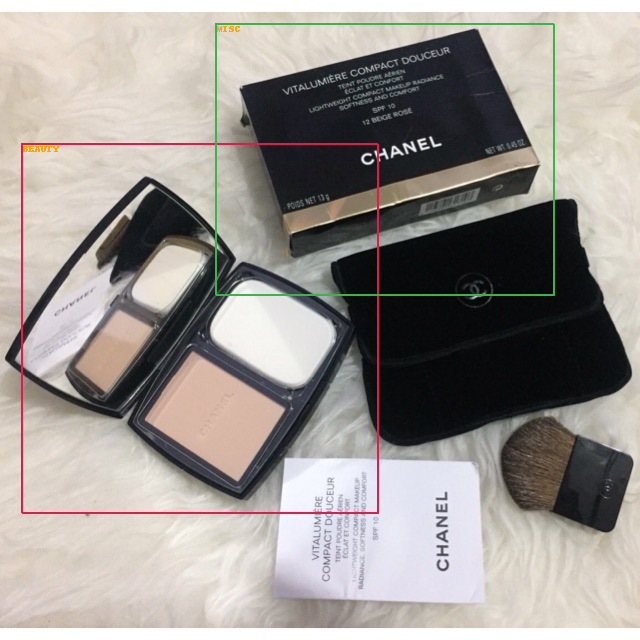

In [26]:
# Load model checkpoint
checkpoint = 'models/BEST_checkpoint_beauty.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
model_beauty = checkpoint['model']
model_beauty = model_beauty.to(device)
model_beauty.eval()

# Load test data image paths
with open('data/derived/TEST_images_beauty.json', 'r') as file:
    test_image_paths_beauty = json.load(file)

original_image = pil_loader(test_image_paths_beauty[0])
detect(original_image, label_map_beauty, model_beauty, device, min_score=0.9, max_overlap=0.5, top_k=200)

Fashion


Loaded checkpoint from epoch 95. Best loss so far is 1.527.



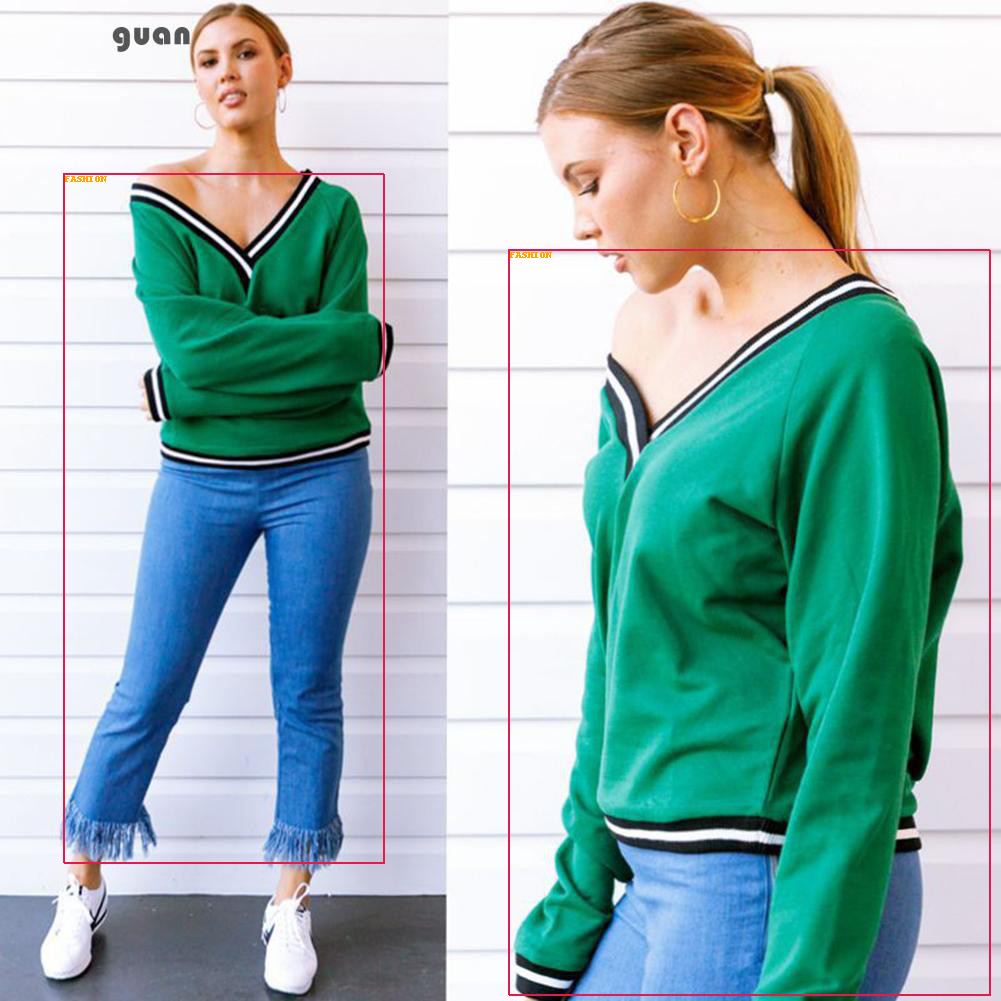

In [27]:
# Load model checkpoint
checkpoint = 'models/BEST_checkpoint_fashion.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
model_fashion = checkpoint['model']
model_fashion = model_fashion.to(device)
model_fashion.eval()

# Load test data image paths
with open('data/derived/TEST_images_fashion.json', 'r') as file:
    test_image_paths_fashion = json.load(file)

original_image = pil_loader(test_image_paths_fashion[0])
detect(original_image, label_map_fashion, model_fashion, device, min_score=0.9, max_overlap=0.5, top_k=200)

Mobile


Loaded checkpoint from epoch 60. Best loss so far is 2.607.



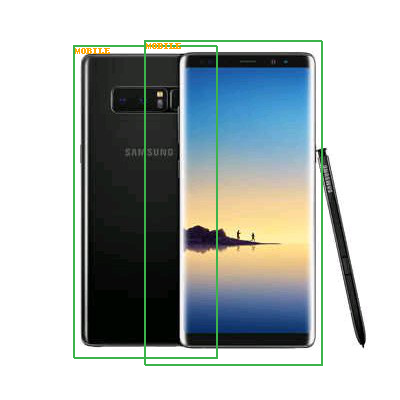

In [28]:
# Load model checkpoint
checkpoint = 'models/BEST_checkpoint_mobile.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['best_loss']
print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
model_mobile = checkpoint['model']
model_mobile = model_mobile.to(device)
model_mobile.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Load test data image paths
with open('data/derived/TEST_images_mobile.json', 'r') as file:
    test_image_paths_mobile = json.load(file)

original_image = pil_loader(test_image_paths_mobile[0])
detect(original_image, label_map_mobile, model_mobile, device, min_score=0.9, max_overlap=0.5, top_k=200)